In [27]:
pip install interactivecrop 
# widget to crop images for data analysis

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#widget'


In [2]:
from interactivecrop.interactivecrop import main as crop #import the interactivecrop widget for use

In [2]:
pip install opencv-python 
# install openCV for use in the widget as well as later use

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#install'


In [3]:
#load in the images and their names to crop each individual image
import os

#create the path to the folder with the images that need cropped
path = r'images_to_crop\\'

image_list = []
image_name_list = []

#filter through the folder to find all the files and their names
for root, dirs, files in os.walk(path):
    for fileName in files:
        image_list.append("./images_to_crop/"+fileName)
        name = fileName.split('.')
        name = name[0]
        image_name_list.append(name)

In [4]:
from PIL import Image, ImageDraw, ImageFont #import functions from the "python imaging library"

# Define the callback to save the image from the crop tool
def callback(image_name, im):
    PIL_im = im.image # Access the PIL image from the 'shape' object
    size = im.get_size() #finds the size of the crop to use for cropping the image
    #im has a rectangle class, so get_size() is needed to output 4 dimensions of the rectangle
    x0 = size[0] #the first two outputs are the corner of the rectangle
    y0 = size[1]
    x1 = size[2] #the next two dimensions are the change in width and height
    y1 = size[3]
    cropImage = PIL_im.crop((x0,y0,x1+x0,y1+y0)) #uses crop to crop the images using the PIL
    cropImage.save('./cropped_images/'+image_name+'_cropped.jpg') #saves the image with _cropped to denote the change and saves it to a new folder with all the cropped images
    
#calls the interactive crop tool to crop the images and denotes the callback function to also save the image
# this function works for a list of images
crop(image_list, image_name_list=image_name_list, callback=callback, crop_shape = 'Rectangle')

# Brief description of how function works:
    # Function creates slider widget that creates an interactive rectangle that adjusts with the slider. The area inside the
    # triangle will then be the area cropped in the saved image
    
    # Save crop sizes must be selected once you are happy with the rectangle (keep small for better accuracy),
    # the function will output the saved images once all the cropped boxes have been selected and saved

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

In [4]:
# import all the needed functions for the next steps

from skimage.transform import (hough_line, hough_line_peaks)
import numpy as np
import cv2
from statistics import mean
import re

In [5]:
path = r'cropped_images\\' #create the path to find the files and initiate lists
crop_image_list = []
crop_names = []

for root, dirs, files in os.walk(path):
    for fileName in files:
        crop_image_list.append("./cropped_images/"+fileName) #create the image list for filtering through cropped images
        name = fileName.split('.')
        val = name[0].split('_')
        crop_names.append(val[0]+'_'+val[1]) #for later printing, don't want the _cropped added b/c unneccessary

In [27]:
braidAngles = [] #initialize the list for braid angles
braidAnglesVert = []

for croppedImage in crop_image_list: #go through all the files in the list to find braid angles
    
    img_gray = cv2.imread(croppedImage) #image is already grayscale, read into python with open cv
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) #perform a gaussian blur to help for edge detection, this smooths the edges
    
    # Sobel Edge Detection
    # sobel edge detection uses a 2D derivative mask to detect the edges in an image, both vertical and horizontal masks are used
    # for the purposes of better identitfying the angles, ddepth is the desired depth of the destination image.

    sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
    
    # Compute arithmetic mean for the hough transformation
    image = np.mean(sobelxy, axis=2)

    # Perform Hough Transformation to detect lines
    hspace, angles, distances = hough_line(image) #hough transform can be used to detect straight lines and their angles
    #transforms into polar coordinates with a rho and a theta

    # Find angle using a function that identifies peaks in the hough transform, finds prominent lines and saves the angles
    angle=[]
    for _, a , dist in zip(*hough_line_peaks(hspace, angles, distances)):
        angle.append(a)

    # Obtain angle in degrees for each line
    angles = [a*180/np.pi for a in angle]
    
    #change negative angle outputs to their positive counterpart, angles measured from counterclockwise between -90 and 90
    angles = [a if (a > 0) else (180 + a) for a in angles]

    
    # from prior measurements, it is known that the maximum braid angle is less than 65degrees and the minimum braid 
    # angle is more than 15 degrees, this allows for the creation of the bounds that no angle should be within 15 degrees of 90,
    # and no angle should be within 25 degrees of 0 or 180

    # we follow this for the further filtration of the angle outputs, knowing all the images are in the same orientation

    angles = [a for a in angles if (a > (90+15) or a < (90-15))] #filters out angles close to 90 for min braid angle
    angles = [a for a in angles if (a < (180-25) and a > (0+25))] #filters out angles close to 0 or 180 for max braid angle

    angRight = [a for a in angles if a < 90] #collects all the angles on the "right side"
    angLeft = [a for a in angles if a > 90] #collects all the angles on the "left side"

    # creates a list of all the angles between all the lines on the right side and all the lines on the left side to find a list of all
    # possible angles, the braid angle is half the value
    braidAngle = []
    for val in angRight:
        for val2 in angLeft:
            ang = (val2-val)/2
            braidAngle.append(ang)
    
    # creates a list of all the angles of the lines as compared to the vertical since this is another way to find the braid angle
    # this method does not as neatly account for slight variations in the angle the picture was taken
    braidAngleVert = []
    for val in angRight:
        ang = 90 - val
        braidAngleVert.append(ang)
    for val in angLeft:
        ang = val - 90
        braidAngleVert.append(ang)

    braidAngle = np.array(braidAngle)
    braidAngleVert = np.array(braidAngleVert)
    # finds the mean of both of the lists and then adds it to the overall list of angles for each image
    braidAngleAvg = np.mean(braidAngle)
    braidAngleVertAvg = np.mean(braidAngleVert)
    
    braidAngles.append(braidAngleAvg)
    braidAnglesVert.append(braidAngleVertAvg)

braidAngles = np.array(braidAngles)
braidAnglesVert = np.array(braidAnglesVert)

In [28]:
braidAnglesVert

array([38.83111302, 36.77573823, 39.43335994, 35.30726257, 34.44134078,
       39.65782123, 36.49687808, 37.26955307, 39.10614525, 39.72067039])

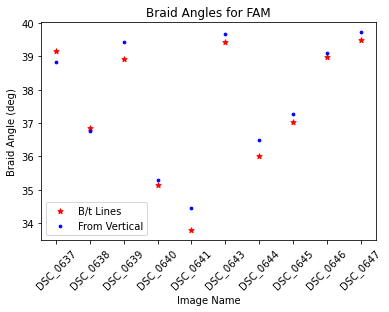

In [29]:
import matplotlib.pyplot as plt # load in the plot ability for data visualization

x = crop_names # easier to define the variables for plotting
y = braidAngles
z = braidAnglesVert

ax = plt.gca() #enables plotting on same graph

# plotting points as a scatter plot
plt.scatter(x, y, label= "B/t Lines", color= "red",
            marker= "*", s=30)
plt.scatter(x, z, label= "From Vertical", color= "blue",
            marker= ".", s=30)

#rotate x ticks for legibility
plt.xticks(rotation=45)
# x-axis label
plt.xlabel('Image Name')
# y-axis label
plt.ylabel('Braid Angle (deg)')
#create legend to label points
ax.legend()
# plot title
plt.title('Braid Angles for FAM')
 
# function to show the plot and save it to the current directory
plt.savefig('Braid Angles for FAM.png', bbox_inches='tight')
plt.show()

In [32]:
#write data to CSV file for later use if user desires
import csv

filename = 'braid_angles.csv' # defines a file name for writing to

#compile data using zip function
rows = zip(crop_names, braidAngles, braidAnglesVert)

with open(filename, 'w') as csvfile: #open and write data to csv file
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Image Name', 'Braid Angle between Lines (deg)', 'Braid Angle from Vertical (deg)']) #creates column labels
    csvwriter.writerows(rows)
csvfile.close()